In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
import re

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import StandardScaler

stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from gensim.models import Word2Vec

from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.naive_bayes import MultinomialNB

In [ ]:
real_news = pd.read_csv('/content/True.csv')

In [ ]:
fake_news = pd.read_csv('/content/Fake.csv')

In [ ]:
real_news.shape

(21417, 4)

In [ ]:
fake_news.shape

(23481, 4)

In [ ]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


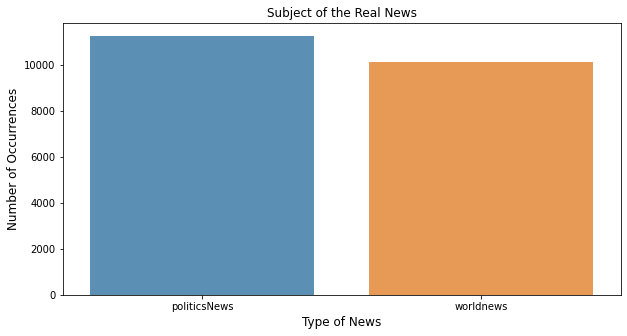

In [ ]:
real_subject_count=real_news['subject'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(real_subject_count.index, real_subject_count.values, alpha=0.8)
plt.title('Subject of the Real News')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of News', fontsize=12)
plt.show()

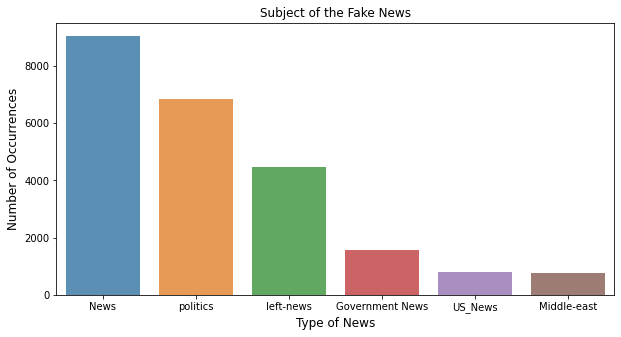

In [ ]:
fake_subject_count=fake_news.subject.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(fake_subject_count.index, fake_subject_count.values, alpha=0.8)
plt.title('Subject of the Fake News')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of News', fontsize=12)
plt.show()

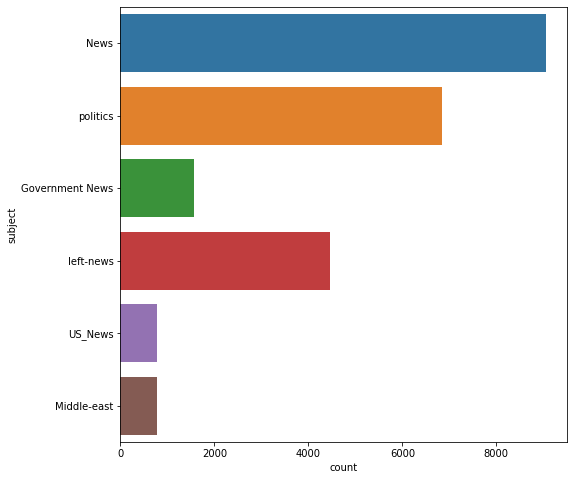

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = fake_news)

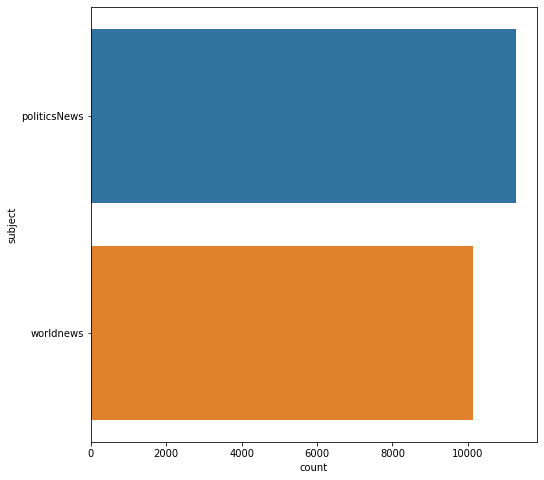

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = real_news)

(-0.5, 399.5, 199.5, -0.5)

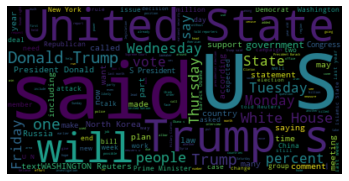

In [ ]:
from wordcloud import WordCloud
wc = WordCloud().generate('text'.join(real_news['text']))
2
plt.imshow(wc, interpolation="bilinear")
3
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

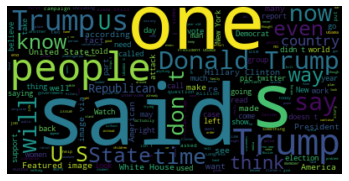

In [ ]:
from wordcloud import WordCloud
wc = WordCloud().generate('text'.join(fake_news['text']))
2
plt.imshow(wc, interpolation="bilinear")
3
plt.axis('off')

In [ ]:
real_news1=real_news[real_news['subject']=='politicsNews']
fake_news1=fake_news[fake_news['subject'].isin(['politics','Government News', 'US_News'])].reset_index(drop=True)

In [ ]:
fake_news1.subject.value_counts(), real_news1.subject.value_counts()

(politics           6841
 Government News    1570
 US_News             783
 Name: subject, dtype: int64, politicsNews    11272
 Name: subject, dtype: int64)

In [ ]:
empty_real_index = [index for index,text in enumerate(real_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news1.iloc[empty_real_index].tail()

No of empty rows: 1


,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [ ]:
empty_fake_index = [index for index,text in enumerate(fake_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_news1.iloc[empty_fake_index].tail()

No of empty rows: 480


,title,text,subject,date
8312,(VIDEO)MILWAUKEE SHERIFF DAVID CLARKE HAMMERS ...,,Government News,"May 8, 2015"
8323,BLACK REPUBLICAN AND BRILLIANT NEUROSURGEON AN...,,Government News,"May 5, 2015"
8325,(VIDEO)INCREDIBLE ACCOUNT FROM SHERIFF MICHAEL...,,Government News,"May 4, 2015"
8337,(VIDEO) RIOTERS TAKE SELFIES WITH TORCHED POLI...,,Government News,"Apr 27, 2015"
8368,TREY GOWDY TO DEA CHIEF ON MISCONDUCT: “WHAT T...,,Government News,"Apr 14, 2015"


In [ ]:
real_news1 = real_news1.drop(8970, axis=0)

In [ ]:
empty_real_index = [index for index,text in enumerate(real_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news1.iloc[empty_real_index].tail()

No of empty rows: 0


,title,text,subject,date


In [ ]:
real_news1['source'] =real_news1.text.str.slice(10, 20)
print(real_news1)

                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
11267  Obama says willing to work with Republican Spe...   
11268  Obama says Islamic State fight far from 'World...   
11269  Chelsea Clinton stands her mother's ground in ...   
11270  Obama jokes about a Trump State of the Union a...   
11271  Clinton expands on plan to tax wealthy as Sand...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv... 

In [ ]:
real_news1.source.value_counts()

 (Reuters)    5939
Reuters) -     768
euters) -      388
(Reuters)      206
uters) - T     129
              ... 
- The FBI        1
- A Virgin       1
- Burlingt       1
/MARIETTA,       1
ters) - If       1
Name: source, Length: 1217, dtype: int64

In [ ]:
real_news1.subject.value_counts()

politicsNews    11271
Name: subject, dtype: int64

In [ ]:
real_news1['label']=1
fake_news1['label']=0

In [ ]:
real_news1.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


In [ ]:
fake_news1.head()

,title,text,subject,date,label
0,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,19-Feb-18,0
1,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,19-Feb-18,0
2,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,19-Feb-18,0
3,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,18-Feb-18,0
4,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,18-Feb-18,0


In [ ]:
fake_news1['title'][1]

'MSNBC ANCHOR Flabbergasted at What Texas Teachers Do to Protect Their Students [Video]'

In [ ]:
fake_news1['text'][1]

'If we protect every other government building or public venue with armed guards, why shouldn t our schools be protected with armed teachers? A Texas Sheriff shocked an MSNBC host when he discussed how he prepares local teachers to be armed in the classroom. common sense solution? You betcha!Sheriff Paul Cairney of Argyle, Texas, described the process by which staff members can carry firearms in the school district. The Sheriff said that the staff at the school who choose to carry a firearm go through an intense round of interviews and training before they are allowed to carry on campus. The MSNBC host was flabbergasted at the practice and asked the Sheriff about concerns for the safety of the students in the school when there are firearms around.Sheriff Cairney:  The time to do nothing is over THE PROCESS TO BECOME A SCHOOL MARSHALL:To become a school marshal, those employees must undergo extensive active shooter and firearms training with the state. They must also undergo a mental he

In [ ]:
news_df = real_news1.append(fake_news1, ignore_index=True)

In [ ]:
news_df.shape

(20465, 6)

In [ ]:
news_df.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


subject
Government News     1570
US_News              783
politics            6841
politicsNews       11271
Name: text, dtype: int64


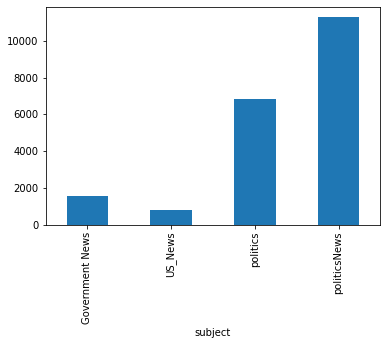

In [ ]:
print(news_df.groupby(['subject'])['text'].count())
news_df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
0     9194
1    11271
Name: text, dtype: int64


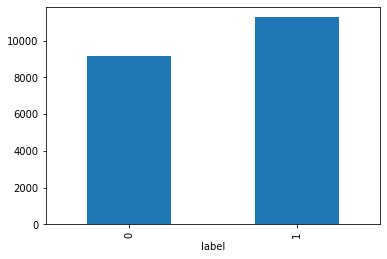

In [ ]:
print(news_df.groupby(['label'])['text'].count())
news_df.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

1    11271
0     9194
Name: label, dtype: int64


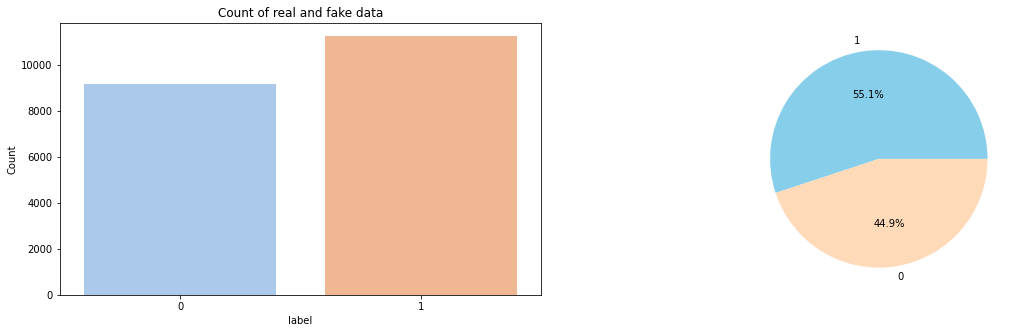

In [ ]:
print(news_df["label"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(news_df.label,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("label")
g2 = plt.pie(news_df["label"].value_counts().values,explode=[0,0],labels=news_df.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

politicsNews       11271
politics            6841
Government News     1570
US_News              783
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

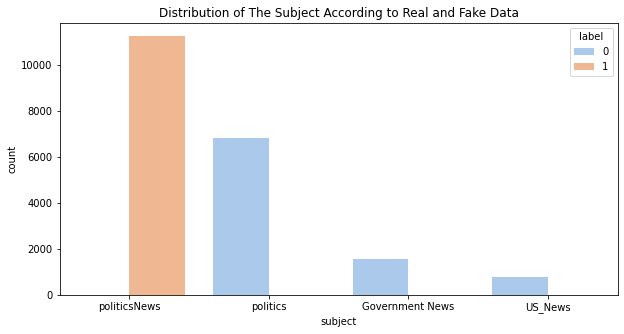

In [ ]:
print(news_df.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='label', data=news_df, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

In [ ]:
import nltk
# let's see the 10 most words used in text:
freq = nltk.FreqDist(' '.join(news_df['text']).split())

freq.most_common(10)

[('the', 416034),
 ('to', 242728),
 ('of', 197256),
 ('a', 177580),
 ('and', 176935),
 ('in', 146464),
 ('that', 95061),
 ('on', 87739),
 ('for', 78649),
 ('is', 64871)]

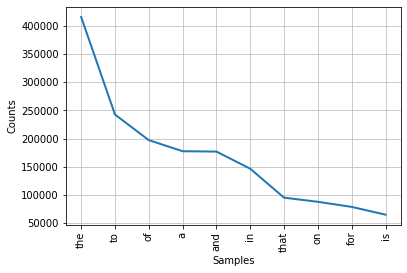

In [ ]:
freq.plot(10)

In [ ]:
import nltk
# let's see the 10 most words used in title:
freq1 = nltk.FreqDist(' '.join(news_df['title']).split())

freq1.most_common(10)

[('Trump', 5233),
 ('to', 4953),
 ('U.S.', 3111),
 ('To', 2594),
 ('on', 2215),
 ('in', 2091),
 ('[Video]', 2065),
 ('of', 1962),
 ('for', 1715),
 ('says', 1457)]

In [ ]:
from nltk import FreqDist
# 10 least used words:
last_ten = FreqDist(dict(freq.most_common()[-10:]))
last_ten

FreqDist({'Die,': 1, 'die!': 1, '(regardless,': 1, 'scary).': 1, 'DUAL': 1, 'LOYALTIES:': 1, 'Mondoweiss,': 1, 'IDF.': 1, 'towards,': 1, 'overdrive.READ': 1})

In [ ]:
from nltk import FreqDist
# 10 least used words:
last_ten1 = FreqDist(dict(freq1.most_common()[-10:]))
last_ten1

FreqDist({'Narrative’': 1, 'Burns,': 1, 'Retreat,': 1, '#38': 1, 'Showdown': 1, 'Looms': 1, 'Ranching': 1, 'Bundys': 1, 'Troubled': 1, 'King:': 1})

In [ ]:
news_df.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


In [ ]:
# Removing the un-important columns

news_df=news_df[['title','text','label']]

In [ ]:
news_df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [ ]:
# in order to remove bias I will shuffle the data
from sklearn.utils import shuffle
news_df = shuffle(news_df)
news_df = news_df.reset_index(drop=True)
news_df

,title,text,label
0,Nordstrom says decision to drop Ivanka Trump's...,CHICAGO (Reuters) - Nordstrom Inc said on Wedn...,1
1,"France, Germany concerned about Trump's moves ...","PARIS (Reuters) - France, Germany and Luxembou...",1
2,Israel PM Netanyahu to meet with Trump on Feb ...,WASHINGTON (Reuters) - Israeli Prime Minister ...,1
3,"Trump administration switches sides, backs Ohi...",(Reuters) - The Trump administration has rever...,1
4,"WHO urges Trump to expand Obamacare, ensure he...",GENEVA (Reuters) - The World Health Organizati...,1
...,...,...,...
20460,ALARMING! THIS STATE’S SCHOOL SYSTEM TO TAKE O...,The ultimate nanny state move in this liberal ...,0
20461,White House says Trump to sign spending bill T...,WASHINGTON (Reuters) - White House budget dire...,1
20462,Gun shops eye busy Black Friday despite Hillar...,SAN FRANCISCO (Reuters) - Christmas came early...,1
20463,Factbox: Political risk outlook calendar for T...,(Reuters) - Financial market concerns are risi...,1


In [ ]:
news_df['text'] = news_df['text'].apply(lambda x: x.lower())
news_df['title'] = news_df['title'].apply(lambda x: x.lower())
# Remove punctuation:
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
news_df['text'] = news_df['text'].apply(punctuation_removal)

In [ ]:
def punctuation_removal(title):
    all_list = [char for char in title if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
news_df['title'] = news_df['title'].apply(punctuation_removal)

In [ ]:
news_df

,title,text,label
0,nordstrom says decision to drop ivanka trumps ...,chicago reuters nordstrom inc said on wednesd...,1
1,france germany concerned about trumps moves to...,paris reuters france germany and luxembourg v...,1
2,israel pm netanyahu to meet with trump on feb ...,washington reuters israeli prime minister ben...,1
3,trump administration switches sides backs ohio...,reuters the trump administration has reversed...,1
4,who urges trump to expand obamacare ensure hea...,geneva reuters the world health organization ...,1
...,...,...,...
20460,alarming this state’s school system to take ov...,the ultimate nanny state move in this liberal ...,0
20461,white house says trump to sign spending bill t...,washington reuters white house budget directo...,1
20462,gun shops eye busy black friday despite hillar...,san francisco reuters christmas came early fo...,1
20463,factbox political risk outlook calendar for tr...,reuters financial market concerns are rising ...,1


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('all')
#establish the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
news_df['text'] = news_df.text.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))
news_df.head(10)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

,title,text,label
0,nordstrom says decision to drop ivanka trumps ...,chicago reuters nordstrom inc said on wednesda...,1
1,france germany concerned about trumps moves to...,paris reuters france germany and luxembourg vo...,1
2,israel pm netanyahu to meet with trump on feb ...,washington reuters israeli prime minister benj...,1
3,trump administration switches sides backs ohio...,reuters the trump administration ha reversed a...,1
4,who urges trump to expand obamacare ensure hea...,geneva reuters the world health organization w...,1
5,anonymous video of bill clinton raping 13 yr o...,anonymous is a loosely associated internationa...,0
6,obama tells 60 minutes he could win a third te...,no obama won t run again but he ll use every d...,0
7,progun university president calls hillary clin...,liberty university president jerry falwell jr ...,0
8,as clock ticks republicans try to move ahead o...,washington reuters the trump administration an...,1
9,watch black conservative destroys mexican flag...,language warning why is it acceptable for peop...,0


In [ ]:
# genrate the token list:
token = ' '.join(news_df.text).split()

In [ ]:
# creating the bigrams
ngrams_2 = nltk.bigrams(token)

# freq distribution for these
freq_2grams = pd.Series(ngrams_2).value_counts().to_dict()
list(freq_2grams.items())[:20]

[(('of', 'the'), 46299),
 (('in', 'the'), 36664),
 (('to', 'the'), 23310),
 (('on', 'the'), 16480),
 (('for', 'the'), 15260),
 (('in', 'a'), 14134),
 (('the', 'u'), 12719),
 (('and', 'the'), 11394),
 (('at', 'the'), 11007),
 (('that', 'the'), 10838),
 (('to', 'be'), 10712),
 (('the', 'united'), 10666),
 (('with', 'the'), 10615),
 (('white', 'house'), 9933),
 (('by', 'the'), 9845),
 (('united', 'state'), 9590),
 (('donald', 'trump'), 9019),
 (('from', 'the'), 8542),
 (('of', 'a'), 8053),
 (('a', 'a'), 7541)]

In [ ]:
# creating the trigrams
ngrams_3 = nltk.trigrams(token)

# freq distribution for these
freq_3grams = pd.Series(ngrams_3).value_counts().to_dict()
list(freq_3grams.items())[:20]

[(('the', 'united', 'state'), 9196),
 (('the', 'white', 'house'), 6235),
 (('said', 'in', 'a'), 3598),
 (('president', 'donald', 'trump'), 3489),
 (('in', 'a', 'statement'), 2940),
 (('one', 'of', 'the'), 2759),
 (('secretary', 'of', 'state'), 2607),
 (('president', 'barack', 'obama'), 2268),
 (('house', 'of', 'representative'), 2236),
 (('according', 'to', 'the'), 1902),
 (('in', 'the', 'united'), 1842),
 (('a', 'well', 'a'), 1833),
 (('member', 'of', 'the'), 1671),
 (('in', 'the', 'u'), 1604),
 (('u', 'president', 'donald'), 1590),
 (('the', 'obama', 'administration'), 1584),
 (('the', 'new', 'york'), 1555),
 (('washington', 'reuters', 'u'), 1511),
 (('the', 'trump', 'administration'), 1450),
 (('president', 'donald', 'trump’s'), 1427)]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(news_df[['title','text']], 
                                                    news_df['label'],  
                                                    test_size = 0.2)

In [ ]:
X_train.head()

,title,text
14499,trump backs waterboarding and a lot more after...,washington reuters republican presidential fro...
11880,petty faa rebukes trump,the faa is getting petty and vindictive the ag...
6254,trump budget chief under fire over attack on c...,washington reuters the white house’s budget ch...
20186,cyber as big a threat as iran north korean icb...,washington reuters constant cyber attack on th...
2721,us plans to admit maximum 45000 refugees in ne...,washington reuters the trump administration pl...


In [ ]:
X_train.tail()

,title,text
16801,sanders steps up feud with democratic establis...,washington reuters democratic presidential can...
2512,trump tells republican lawmakers enough talk t...,philadelphia reuters president donald trump pu...
20278,mizzou crybabies complain paris terror tragedy...,never mind that almost every single aspect of ...
15389,lol democrats express concerns over possible c...,a progressive group charged saturday that the ...
13079,russia probe should focus on trump financial t...,washington reuters a u senate investigation in...


In [ ]:
#Since title is also important so combining it with the text

train_data= np.asarray(list(X_train['title']+" "+X_train['text']))
test_data = np.asarray(list(x_test['title']+" "+x_test['text']))

In [ ]:
train_data[0]

'trump backs waterboarding and a lot more after brussels attacks washington reuters republican presidential frontrunner donald trump said on tuesday the united state should use waterboarding and other harsh interrogation technique when questioning terror suspect and renewed his call for tougher u border security after the attack in brussels the billionaire businessman said authority “should be able to do whatever they have to do” to gain information in an effort to thwart future attack “waterboarding would be fine if they can expand the law i would do a lot more than waterboarding” trump said on nbc’s “today” program adding he believed torture could produce useful lead “you have to get the information from these people” waterboarding the practice of pouring water over someone’s face to simulate drowning a an interrogation tactic wa banned by president barack obama day after he took office in 2009 critic call it torture trump’s main republican rival u senator ted cruz of texas suggested

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
from tqdm import tqdm
# tqdm is for printing the status bar
# Getting list of stop words fron nltk
en_stops = set(stopwords.words('english'))

def process(data):
    preprocessed_tweets = []

    for sentance in tqdm(data):
        sentance = re.sub(r"http\S+", "", sentance) # removing the html tags
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in en_stops)
        preprocessed_tweets.append(sentance.strip())
        
    return preprocessed_tweets

In [ ]:
preprocess_train_data=process(train_data)
preprocess_test_data=process(test_data)

100%|██████████| 4093/4093 [00:03<00:00, 1039.44it/s]


In [ ]:
# Tokenizing the train data sentence

cleaned_train_data=[]
for sent in preprocess_train_data:
    cleaned_train_data.append(sent.split()) 

In [ ]:
# Tokenizing the test data sentence
cleaned_test_data =[]   
for sent in preprocess_test_data:
    cleaned_test_data.append(sent.split())

In [ ]:
cleaned_train_data[0][:10]

['trump',
 'backs',
 'waterboarding',
 'lot',
 'brussels',
 'attacks',
 'washington',
 'reuters',
 'republican',
 'presidential']

In [ ]:
# Creating a word2vec model on the dataset
# vector_size -Dimensionality of the word vectors. 
# min_count – Ignores all words with total frequency lower than this.
# sg  – Training algorithm: 1 for skip-gram; otherwise CBOW.
# window – Maximum distance between the current and predicted word within a sentence

word2vec_model=Word2Vec(cleaned_train_data,size=300,min_count=1,workers=3, window =3, sg = 1)

In [ ]:
#creating function to calculate the average word vectorizer

def Word2Vectorizer(data,model,size):
    vectors = []
    for sent in data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    return np.nan_to_num(vectors)

In [ ]:
train_av_w2v=Word2Vectorizer(cleaned_train_data,word2vec_model,300)
test_av_w2v=Word2Vectorizer(cleaned_test_data,word2vec_model,300)

In [ ]:
word2vec_model.wv.most_similar("saudi")

[('arabia', 0.9290183782577515),
 ('riyadh', 0.740433931350708),
 ('arabian', 0.716070294380188),
 ('qatar', 0.7122907638549805),
 ('uae', 0.7014089226722717),
 ('qatari', 0.6852827072143555),
 ('bahrain', 0.682198703289032),
 ('egypt', 0.6753093004226685),
 ('saudia', 0.6715283393859863),
 ('hijacker', 0.6669340133666992)]

In [ ]:
train_av_w2v[1]

array([-1.07001216e-01,  3.76036746e-02, -4.27958486e-02, -9.49790922e-02,
        1.74359962e-01, -2.26625473e-02,  1.09674630e-02,  1.71012739e-02,
       -1.58202714e-01, -1.18777903e-02,  5.37574343e-03,  2.06482754e-01,
       -1.10192552e-01,  6.99874487e-02, -1.04421695e-01, -1.45918879e-01,
        1.03621520e-01, -1.90534128e-01, -5.45202437e-02,  1.12897681e-01,
        1.00548018e-01,  3.74687011e-02,  1.60332671e-01, -9.17192104e-02,
       -5.18500509e-02,  7.65012726e-02, -5.16135413e-02, -2.32471554e-01,
        5.93373216e-02,  3.78439259e-01, -6.32768551e-02,  1.61431585e-01,
        1.61623869e-01, -9.40662401e-02, -6.24905394e-02,  1.34922754e-01,
       -2.61151288e-01,  3.35306348e-02, -3.60163115e-02, -8.21857638e-02,
       -1.25006123e-01, -3.56917379e-02, -9.33495533e-02,  1.20570111e-01,
       -6.42842833e-02, -3.31047361e-02,  1.11237202e-01, -1.51691282e-01,
       -1.47524099e-01,  4.30816731e-02, -6.19494652e-02, -8.21465894e-02,
       -4.96317294e-02,  

In [ ]:
# combining the processed text data with dependent variable
processed_data=pd.DataFrame(train_av_w2v)
processed_data['label']=news_df['label']

In [ ]:
# Saving the processed train data

processed_data.to_csv('final_train.csv',index=False)

In [ ]:
X_train=train_av_w2v
x_test=test_av_w2v

In [ ]:
def trainconfusionmatrix(model,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, model.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
def testconfusionmatrix(model,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, model.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
def Grid_SearchCV(model,X_train,Y_train,param_grid):
    
    tscv = TimeSeriesSplit(n_splits=10)
    
    gsv=GridSearchCV(model,param_grid,cv=tscv,verbose=1,scoring='f1')
    gsv.fit(X_train,Y_train)
    
    return gsv

In [ ]:
#Finding the best value Of hyperparameter

from sklearn.ensemble import RandomForestClassifier

param_grid= {'max_depth':[1,5,10,50,100,500,1000],
             'n_estimators' :[5,10,20,50,100]
            }

gsv=Grid_SearchCV(RandomForestClassifier(class_weight='balanced'),X_train,Y_train,param_grid)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best HyperParameter:  {'max_depth': 100, 'n_estimators': 100}
Best Accuracy: 94.55%


In [ ]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']
Model_Random_Forest=RandomForestClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_Random_Forest.fit(X_train,Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100)

Confusion Matrix for Train set


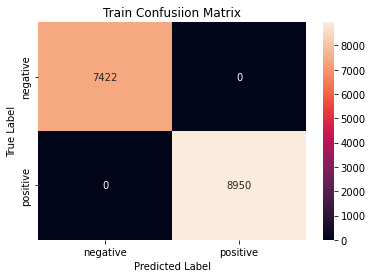

In [ ]:
trainconfusionmatrix(Model_Random_Forest,X_train,Y_train)

Confusion Matrix for Test set


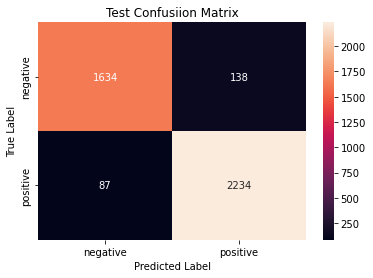

In [ ]:
testconfusionmatrix(Model_Random_Forest,x_test,y_test)


In [ ]:
print("Train Classification Report: \n")
y_pred_train=Model_Random_Forest.predict(X_train)
print(classification_report(Y_train, y_pred_train))

Train Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7422
           1       1.00      1.00      1.00      8950

    accuracy                           1.00     16372
   macro avg       1.00      1.00      1.00     16372
weighted avg       1.00      1.00      1.00     16372



In [ ]:
print("Test Classification Report: \n")
y_pred_test=Model_Random_Forest.predict(x_test)
print(classification_report(y_test, y_pred_test))

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1772
           1       0.94      0.96      0.95      2321

    accuracy                           0.95      4093
   macro avg       0.95      0.94      0.94      4093
weighted avg       0.95      0.95      0.94      4093



In [ ]:
from xgboost import XGBClassifier

param_grid= {'max_depth':[1,5,10,50,100,500,1000],
              'n_estimators' :[5,10,20,50,100]
            }


gsv=Grid_SearchCV(XGBClassifier(),X_train,Y_train,param_grid)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best HyperParameter:  {'max_depth': 5, 'n_estimators': 100}
Best Accuracy: 95.78%


In [ ]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']
Model_XGB=XGBClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_XGB.fit(X_train,Y_train)

XGBClassifier(class_weight='balanced', max_depth=5)

Confusion Matrix for Train set


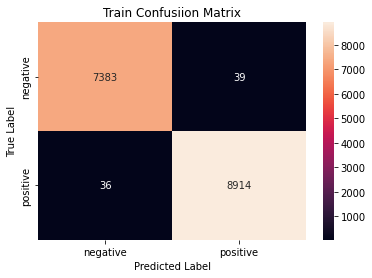

In [ ]:
trainconfusionmatrix(Model_XGB,X_train,Y_train)

Confusion Matrix for Test set


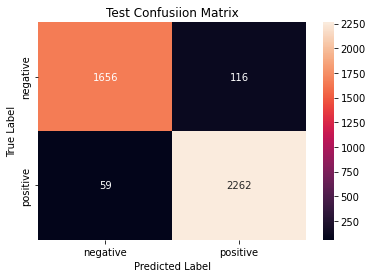

In [ ]:
testconfusionmatrix(Model_XGB,x_test,y_test)

In [ ]:
print("Train Classification Report: \n")
y_pred_train=Model_XGB.predict(X_train)
print(classification_report(Y_train, y_pred_train))

Train Classification Report: 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7422
           1       1.00      1.00      1.00      8950

    accuracy                           1.00     16372
   macro avg       1.00      1.00      1.00     16372
weighted avg       1.00      1.00      1.00     16372



In [ ]:
print("Test Classification Report: \n")
y_pred_test2=Model_XGB.predict(x_test)
print(classification_report(y_test, y_pred_test))

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1772
           1       0.94      0.96      0.95      2321

    accuracy                           0.95      4093
   macro avg       0.95      0.94      0.94      4093
weighted avg       0.95      0.95      0.94      4093



In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Accuracy = logreg.score(x_test, y_test)
print(Accuracy*100)

96.31077449303689


In [ ]:
print("Test Classification Report: \n")
y_pred_test1=logreg.predict(x_test)
print(classification_report(y_test, y_pred_test1))

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1772
           1       0.95      0.98      0.97      2321

    accuracy                           0.96      4093
   macro avg       0.96      0.96      0.96      4093
weighted avg       0.96      0.96      0.96      4093



Confusion Matrix for Test set


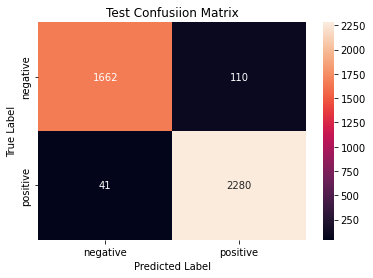

In [ ]:
testconfusionmatrix(logreg,x_test,y_test)

In [ ]:
from joblib import Parallel, delayed
import joblib
  
joblib.dump(Model_Random_Forest, 'Model_Random_Forest.pkl')

['Model_Random_Forest.pkl']

In [ ]:
joblib.dump(Model_XGB, 'Model_XGB.pkl')

['Model_XGB.pkl']

In [ ]:
joblib.dump(logreg, 'Model_logreg.pkl')

['Model_logreg.pkl']

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests

url = "https://edition.cnn.com/2022/09/16/politics/donald-trump-hugh-hewitt-interview-indicted/index.html"

# To fetch the url
#html = requests.get(url)

html = urlopen(url)

# Using beautiful soup to pull the html data 
soup = BeautifulSoup(html,"html.parser")

# finding the tag in which the content is present
a = soup.findAll("p",class_="paragraph inline-placeholder")

# Adding all the data in a lists
l=[]

for x in a[2:]:
    l.append(x.text.strip("\n"))
    
data=pd.DataFrame(l,columns=['text'])

In [ ]:
data['text'][0]

'Hewitt: You know the old saying. A prosecutor can indict a ham sandwich if they want to. I’m just asking if there is such a prosecutor and they indict you, would that deter you from running for president again?'

In [ ]:
df1 = pd.DataFrame.from_records(data)
df1.head(10)

,text
0,Hewitt: You know the old saying. A prosecutor ...
1,Trump: I don’t think the people of the United ...
2,Hewitt: I do. That’s what I wanted people to u...
3,Trump: It would not. But I think if it happene...
4,"Hewitt: What kind of problems, Mr. President."
5,"Trump: I think they’d have big problems, big p..."
6,It’s impossible to read those lines from...
7,"Hewitt, sensing that Trump had wandered ..."
8,"To which Trump responded: “That’s not, t..."
9,(Sidebar: The dictionary definition of “...


In [ ]:
# Saving the  ata
df1.to_csv("article1_data.csv")

In [ ]:
# model = trained word2vec model
# data= retrieve data from the article
# size = the size given at the time of word2vec embedding i.e in this case 300

def prediction_data_process(model,data,size):
    
    prediction_data=np.asarray(list(data['text']))
    prediction_data=process(prediction_data)
    cleaned_prediction_data=[]
    for sent in prediction_data:
        cleaned_prediction_data.append(sent.split()) 
        
    vectors = []
    for sent in cleaned_prediction_data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = word2vec_model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    
    return np.nan_to_num(vectors)

In [ ]:
final_prediction_data=prediction_data_process(word2vec_model,data,300)

100%|██████████| 15/15 [00:00<00:00, 4163.77it/s]


In [ ]:
final_prediction_data[3][1:10]

array([ 0.04496035,  0.0429005 , -0.14297589,  0.07758826, -0.10931012,
        0.01204928,  0.07038387, -0.07005778,  0.05122528])

In [ ]:
len(final_prediction_data)

15

In [ ]:
from joblib import Parallel, delayed
import joblib
# Load the model from the file

RF_Model = joblib.load('Model_Random_Forest.pkl')

In [ ]:
RF_Model.predict(final_prediction_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [ ]:
RF_Model.predict_proba(final_prediction_data)

array([[0.78, 0.22],
       [0.55, 0.45],
       [0.61, 0.39],
       [0.57, 0.43],
       [0.63, 0.37],
       [0.69, 0.31],
       [0.87, 0.13],
       [0.78, 0.22],
       [0.39, 0.61],
       [0.92, 0.08],
       [0.82, 0.18],
       [0.36, 0.64],
       [0.71, 0.29],
       [0.82, 0.18],
       [0.51, 0.49]])

In [ ]:
RF_p = [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

df1['RF_p'] = RF_p

In [ ]:
df1

,text,RF_p
0,Hewitt: You know the old saying. A prosecutor ...,0
1,Trump: I don’t think the people of the United ...,0
2,Hewitt: I do. That’s what I wanted people to u...,0
3,Trump: It would not. But I think if it happene...,1
4,"Hewitt: What kind of problems, Mr. President.",0
5,"Trump: I think they’d have big problems, big p...",0
6,It’s impossible to read those lines from...,0
7,"Hewitt, sensing that Trump had wandered ...",0
8,"To which Trump responded: “That’s not, t...",1
9,(Sidebar: The dictionary definition of “...,0


In [ ]:
df1['RF_p'].value_counts()

0    13
1     2
Name: RF_p, dtype: int64

In [ ]:
RF_Model.predict(final_prediction_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [ ]:
logreg

LogisticRegression()

In [ ]:
!pip install --upgrade --user praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
!pip3 install praw --upgrade --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached praw-7.6.1-py3-none-any.whl (188 kB)
  Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
  Using cached websocket_client-1.4.2-py3-none-any.whl (55 kB)
  Using cached prawcore-2.3.0-py3-none-any.whl (16 kB)
     |████████████████████████████████| 62 kB 898 kB/s 
     |████████████████████████████████| 155 kB 10.3 MB/s 
     |████████████████████████████████| 61 kB 87 kB/s 
     |████████████████████████████████| 140 kB 43.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: idna
    Found existing installation: idna 2.10
    Uninstalling idna-2.10:
      Successfully uninstalled idna-2.10
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.1.1
    Uninstalling charset-normalizer-2.1.

In [ ]:
import seaborn as sns
from IPython import display
from pprint import pprint
import praw
reddit = praw.Reddit(client_id='RNsXG7wsMtIsaHStOErUrA',
client_secret='ZzRMNAa8pxD5gE2Cws8_OvBzD8wg4A',
user_agent='Amin8686') 

In [ ]:
news = set() 
for sub in reddit.subreddit('politics').new(limit=400):
    news.add(sub.title)
print(len(news))

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



400


In [ ]:
news

{"'Don't Say Gay' Florida lawmaker Rep. Joe Harding indicted on COVID-19 relief fraud charges",
 "'Don't Say Gay' Florida lawmaker indicted on fraud charges",
 '8 bad things that have happened to Trump in the 3 weeks since he launched his presidential campaign',
 '9 million Americans were wrongly told they were approved for student debt forgiveness',
 'A Billionaire Got the Chicago Mayor’s Support to Lease Public Land. Then He Wrote Her Campaign a $25,000 Check.',
 'A Redistricting Case at the Supreme Court May Overhaul Elections',
 'A former Florida congressman is arrested on charges of lobbying for Venezuela',
 'A new day? Voters stood up for democracy — and now we have the data|America has a long way to go in redeeming democracy — but the midterm exit polls tell a story of hope',
 'AOC Is Under Investigation by the House Ethics Committee',
 'AOC facing House Ethics Committee investigation',
 'Absolute Madness: The Warnock-Walker Runoff Should Never Have Been This Close',
 'After Con

In [ ]:
# Create sub-reddit instance
subreddit_name = "politics"
subreddit = reddit.subreddit(subreddit_name)

df = pd.DataFrame() # creating dataframe for displaying scraped data

# creating lists for storing scraped data
titles=[]
posts=[]
ids=[]

# looping over posts and scraping it
for submission in subreddit.top(limit=300):
    titles.append(submission.title)
    posts.append(submission.score) #upvotes
    ids.append(submission.id)
    
    
df['Title'] = titles
df['Id'] = ids
df['posts'] = posts #upvotes

print(df.shape)
df.head(10)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



(300, 3)


,Title,Id,posts
0,Megathread: Joe Biden Projected to Defeat Pres...,jptq5n,214314
1,Mitch McConnell Will Lose Control Of The Senat...,krntg6,156744
2,Megathread: House Votes to Impeach President D...,ecm1zg,147744
3,Trump Threatens to ‘Leave the Country’ if He L...,jcm5dz,135305
4,Demands for Kushner to Resign Over 'Staggering...,i19sjg,129740
5,Over A million people sign petition calling fo...,h7ic8s,129202
6,Report: Biden Admin Discovers Trump Had Zero P...,l1ynt4,127955
7,Biden's Pennsylvania lead is now big enough to...,jsi48r,125944
8,Donald Trump Has Just Left the White House—Thi...,l1902k,125234
9,Virginia governor makes Election Day a holiday...,g03uny,124068


In [ ]:
# Removing the un-important columns
df=df[['Title']]

In [ ]:
df['Title'][0]

'Megathread: Joe Biden Projected to Defeat President Donald Trump and Win the 2020 US Presidential Election'

In [ ]:
df.isnull().sum()

Title    0
dtype: int64

In [ ]:
empty_index = [index for index,Title in enumerate(df.Title.values) if str(Title).strip() == '']
print(f"No of empty rows: {len(empty_index)}")
df.iloc[empty_index].tail()

No of empty rows: 0


,Title


In [ ]:
nltk.download('wordnet')
#establish the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
df['Title'] = df.Title.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))
df.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title
0,Megathread: Joe Biden Projected to Defeat Pres...
1,Mitch McConnell Will Lose Control Of The Senat...
2,Megathread: House Votes to Impeach President D...
3,Trump Threatens to ‘Leave the Country’ if He L...
4,Demands for Kushner to Resign Over 'Staggering...
5,Over A million people sign petition calling fo...
6,Report: Biden Admin Discovers Trump Had Zero P...
7,Biden's Pennsylvania lead is now big enough to...
8,Donald Trump Has Just Left the White House—Thi...
9,Virginia governor make Election Day a holiday ...


In [ ]:
# in order to remove bias I will shuffle the data
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index(drop=True)
df
# Convert the text to lowercase:
df['Title'] = df['Title'].apply(lambda x: x.lower())
# Remove punctuation:
import string
def punctuation_removal(Title):
    all_list = [char for char in Title if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
df['Title'] = df['Title'].apply(punctuation_removal)

In [ ]:
stop = stopwords.words('english')
df['Title'] = df.Title.apply(lambda x: " ".join(w for w in x.split() if w not in stop))
df.head(10)

,Title
0,biden sign inflation reduction act law setting...
1,50 state dc certified presidential election re...
2,fauci say accepted bidens offer chief medical ...
3,pentagon cancel contract build trump’s border ...
4,impeach justice clarence thomas petition pass ...
5,“it’s longer political party it’s cult” former...
6,kamala harris break 5050 tie begin senate deba...
7,six republican lawmaker among rioter police re...
8,mcconnell block house bill reopen government s...
9,trump flew rage every time us intelligence war...


(-0.5, 399.5, 199.5, -0.5)

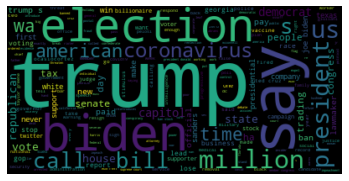

In [ ]:
wc = WordCloud().generate('Title'.join(df['Title']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')

In [ ]:
# genrate the token list:
token1 = ' '.join(df.Title).split()

In [ ]:
# creating the bigrams
ngrams_2 = nltk.bigrams(token1)

# freq distribution for these
freq_2grams = pd.Series(ngrams_2).value_counts().to_dict()
list(freq_2grams.items())[:20]

[(('joe', 'biden'), 11),
 (('bernie', 'sanders'), 9),
 (('donald', 'trump'), 9),
 (('supreme', 'court'), 6),
 (('alexandria', 'ocasiocortez'), 5),
 (('ted', 'cruz'), 5),
 (('member', 'congress'), 4),
 (('elizabeth', 'warren'), 4),
 (('capitol', 'riot'), 4),
 (('president', 'trump'), 4),
 (('trump', 'administration'), 4),
 (('ban', 'stock'), 4),
 (('president', 'donald'), 4),
 (('taylor', 'greene'), 4),
 (('marjorie', 'taylor'), 4),
 (('trump', 'campaign'), 4),
 (('election', 'day'), 3),
 (('make', 'election'), 3),
 (('white', 'house'), 3),
 (('megathread', 'president'), 3)]

In [ ]:
# creating the trigrams
ngrams_3 = nltk.trigrams(token1)

# freq distribution for these
freq_3grams = pd.Series(ngrams_3).value_counts().to_dict()
list(freq_3grams.items())[:20]

[(('marjorie', 'taylor', 'greene'), 4),
 (('make', 'election', 'day'), 3),
 (('throws', 'trump', 'campaign'), 2),
 (('donald', 'j', 'trump'), 2),
 (('sen', 'elizabeth', 'warren'), 2),
 (('elizabeth', 'warren', 'want'), 2),
 (('robert', 'e', 'lee'), 2),
 (('us', 'election', 'biden'), 2),
 (('refuse', 'wear', 'mask'), 2),
 (('president', 'donald', 'j'), 2),
 (('bill', 'bar', 'lawmaker'), 2),
 (('judge', 'throws', 'trump'), 2),
 (('election', 'day', 'holiday'), 2),
 (('impeach', 'president', 'donald'), 2),
 (('votes', 'impeach', 'president'), 2),
 (('house', 'votes', 'impeach'), 2),
 (('bar', 'lawmaker', 'trading'), 2),
 (('lawmaker', 'trading', 'stock'), 2),
 (('reintroduces', 'bill', 'bar'), 2),
 (('warren', 'reintroduces', 'bill'), 2)]

In [ ]:
# model = trained word2vec model
# data= retrieved data from Reddit
# size = the size given at the time of word2vec embedding i.e in this case 300

def prediction_data_process(model,df,size):
    
    prediction_data=np.asarray(list(df['Title']))
    prediction_data=process(prediction_data)
    cleaned_prediction_data=[]
    for sent in prediction_data:
        cleaned_prediction_data.append(sent.split()) 
        
    vectors = []
    for sent in cleaned_prediction_data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = word2vec_model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    
    return np.nan_to_num(vectors)

In [ ]:
final_prediction_data1=prediction_data_process(word2vec_model,df,300)

100%|██████████| 300/300 [00:00<00:00, 13863.02it/s]


In [ ]:
# Saving the processed data

pd.DataFrame(final_prediction_data1).to_csv("Reddit_data.csv")

In [ ]:
final_prediction_data1[3][1:10]

array([-0.04665942, -0.08577795, -0.15008999,  0.13615345, -0.01743746,
        0.02118362,  0.11962936, -0.31247888, -0.19656156])

In [ ]:
from joblib import Parallel, delayed
import joblib
  
  
# Load the model from the file

RF_Model = joblib.load('Model_Random_Forest.pkl')

In [ ]:
RF_Model.predict(final_prediction_data1)

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
# creating a list for new column
RF_pred = [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
df['RF_pred'] = RF_pred

In [ ]:
df

,Title,RF_pred
0,biden sign inflation reduction act law setting...,1
1,50 state dc certified presidential election re...,1
2,fauci say accepted bidens offer chief medical ...,0
3,pentagon cancel contract build trump’s border ...,1
4,impeach justice clarence thomas petition pass ...,1
...,...,...
295,forbes editor issue warning company intending ...,0
296,gop lawmaker voted paid sick leave florida tak...,0
297,noticed 200 million missing fired alice stebbi...,0
298,donald trump left white house—this time good,1


In [ ]:
Model_XGB = joblib.load('Model_XGB.pkl')

In [ ]:
Model_XGB.predict(final_prediction_data1)

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
XGB_pred = [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
df['XGB_pred'] = XGB_pred

In [ ]:
df

,Title,RF_pred,XGB_pred
0,biden sign inflation reduction act law setting...,1,1
1,50 state dc certified presidential election re...,1,1
2,fauci say accepted bidens offer chief medical ...,0,0
3,pentagon cancel contract build trump’s border ...,1,0
4,impeach justice clarence thomas petition pass ...,1,0
...,...,...,...
295,forbes editor issue warning company intending ...,0,0
296,gop lawmaker voted paid sick leave florida tak...,0,0
297,noticed 200 million missing fired alice stebbi...,0,0
298,donald trump left white house—this time good,1,1


In [ ]:
logreg = joblib.load('Model_logreg.pkl')

In [ ]:
logreg.predict(final_prediction_data1)

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [ ]:
LR_pred = [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]
df['LR_pred'] = LR_pred

In [ ]:
df

,Title,RF_pred,XGB_pred,LR_pred
0,biden sign inflation reduction act law setting...,1,1,1
1,50 state dc certified presidential election re...,1,1,1
2,fauci say accepted bidens offer chief medical ...,0,0,0
3,pentagon cancel contract build trump’s border ...,1,0,0
4,impeach justice clarence thomas petition pass ...,1,0,0
...,...,...,...,...
295,forbes editor issue warning company intending ...,0,0,0
296,gop lawmaker voted paid sick leave florida tak...,0,0,0
297,noticed 200 million missing fired alice stebbi...,0,0,0
298,donald trump left white house—this time good,1,1,1


0    182
1    118
Name: RF_pred, dtype: int64


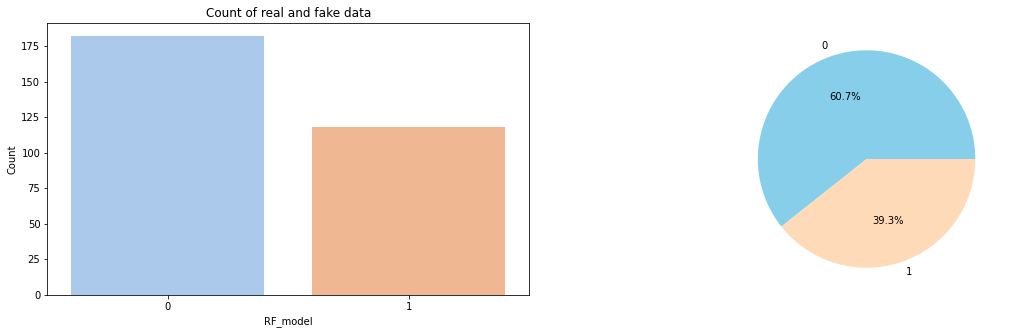

In [ ]:
print(df["RF_pred"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.RF_pred,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("RF_model")
g2 = plt.pie(df["RF_pred"].value_counts().values,explode=[0,0],labels=df.RF_pred.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

0    215
1     85
Name: XGB_pred, dtype: int64


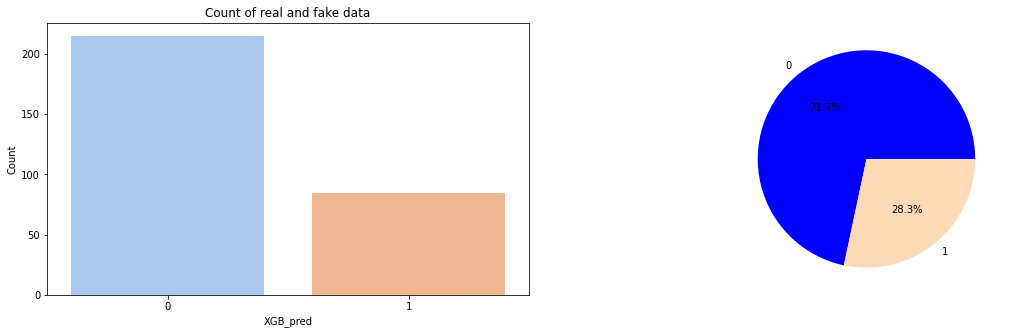

In [ ]:
print(df["XGB_pred"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.XGB_pred,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("XGB_pred")
g2 = plt.pie(df["XGB_pred"].value_counts().values,explode=[0,0],labels=df.XGB_pred.value_counts().index, autopct='%1.1f%%',colors=['Blue','PeachPuff'])
fig.show()

0    205
1     95
Name: LR_pred, dtype: int64


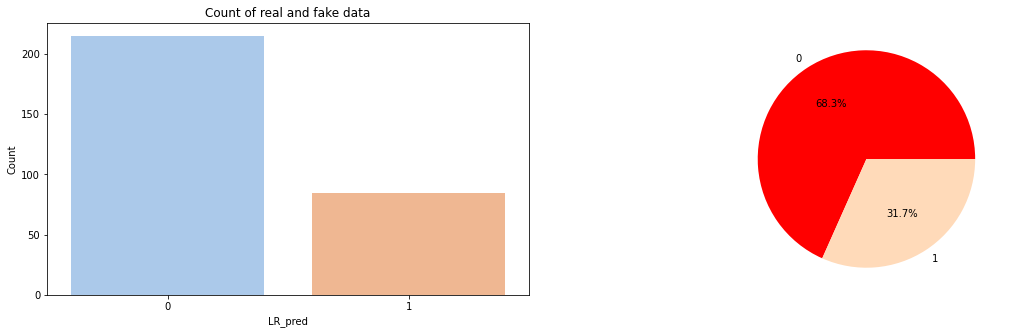

In [ ]:
print(df["LR_pred"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.XGB_pred,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("LR_pred")
g2 = plt.pie(df["LR_pred"].value_counts().values,explode=[0,0],labels=df.LR_pred.value_counts().index, autopct='%1.1f%%',colors=['Red','PeachPuff'])
fig.show()